In [71]:
import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.optim import lr_scheduler
import datetime
import numpy as np
import argparse
from torchsummary import summary

In [72]:
num_epochs = 50
batch_size = 2048
learning_rate = 1e-3

train_transform = transforms.Compose([transforms.ToTensor()])
train_set = MNIST('./data/mnist', train=True, download=True, transform=train_transform)
dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
device = torch.device('cuda')

# idx = int(input("Pick a number: "))

# plt.imshow(train_set.data[idx], cmap='gray')
# plt.show()

In [73]:
class autoencoderMLP4(nn.Module):
    def __init__(self, N_input=784, N_bottleneck=16, N_output=784):
        super(autoencoderMLP4, self).__init__()
        N2 = 392
        self.fc1 = nn.Linear(N_input, N2)
        self.fc2 = nn.Linear(N2, N_bottleneck)
        self.fc3 = nn.Linear(N_bottleneck, N2)
        self.fc4 = nn.Linear(N2, N_output)
        self.type = "MLP4"
        self.input_shape = (1, 28*28)
        
    def forward(self, X):
        X = self.fc1(X)
        X = F.relu(X)
        X = self.fc2(X)

        X = self.fc3(X)
        X = F.relu(X)
        X = self.fc4(X)
        X = torch.sigmoid(X)

        return X
    
    def encode(self, X):
        X = self.fc1(X)
        X = F.relu(X)
        X = self.fc2(X)

        return X

    def decode(self, X):
        X = self.fc3(X)
        X = F.relu(X)
        X = self.fc4(X)
        X = torch.sigmoid(X)

        return X

In [74]:
def train(n_epochs, optimizer, model, loss_fn, train_loader, scheduler, device):
    model.train().to(device)
    losses_train = []
    
    for epoch in range(1, n_epochs+1):
        print('epoch ', epoch)
        loss_train = 0.0
        for imgs in train_loader:
            img, _ = imgs
            img = img.view(img.size(0), -1)
            img = Variable(img).to(device)
            outputs = model(img).to(device)
            loss = loss_fn(outputs, img)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()

        scheduler.step(loss_train)

        losses_train += [loss_train/len(train_loader)]

        print('{} Epoch {}, Training loss {}'.format(datetime.datetime.now(), epoch, loss_train/len(train_loader)))
    plt.style.use('fivethirtyeight')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.plot(losses_train[-100:])
    plt.show()

epoch  1


c:\Users\steve\OneDrive\Desktop\eng stuff\FOURTH YEAR\ELEC 475\test project\elec475\Lib\site-packages\torch\optim\lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2023-09-15 22:49:20.308264 Epoch 1, Training loss 0.1063038575152556
epoch  2
2023-09-15 22:49:25.516642 Epoch 2, Training loss 0.0643169707308213
epoch  3
2023-09-15 22:49:30.558942 Epoch 3, Training loss 0.051995452493429184
epoch  4
2023-09-15 22:49:35.600119 Epoch 4, Training loss 0.04423357062041759
epoch  5
2023-09-15 22:49:40.612536 Epoch 5, Training loss 0.03882016738255819
epoch  6
2023-09-15 22:49:45.655516 Epoch 6, Training loss 0.034671667590737344
epoch  7
2023-09-15 22:49:50.570084 Epoch 7, Training loss 0.030940141466756662
epoch  8
2023-09-15 22:49:55.044078 Epoch 8, Training loss 0.027569842090209327
epoch  9
2023-09-15 22:50:00.391867 Epoch 9, Training loss 0.024757643540700276
epoch  10
2023-09-15 22:50:05.941050 Epoch 10, Training loss 0.022748872575660547
epoch  11
2023-09-15 22:50:10.886023 Epoch 11, Training loss 0.02098940542588631
epoch  12
2023-09-15 22:50:15.798705 Epoch 12, Training loss 0.019648403488099576
epoch  13
2023-09-15 22:50:21.495367 Epoch 13, Tra

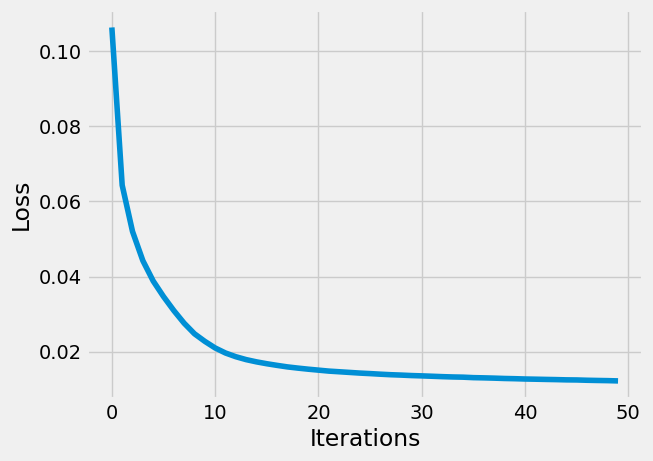

In [75]:
model = autoencoderMLP4().to(device)
loss_f = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)
train(num_epochs, optimizer, model, loss_f, dataloader, scheduler, device)

In [76]:
summary(model, (1, 28*28))

Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [-1, 1, 392]              307,720
├─Linear: 1-2                            [-1, 1, 16]               6,288
├─Linear: 1-3                            [-1, 1, 392]              6,664
├─Linear: 1-4                            [-1, 1, 784]              308,112
Total params: 628,784
Trainable params: 628,784
Non-trainable params: 0
Total mult-adds (M): 0.63
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 2.40
Estimated Total Size (MB): 2.41


Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [-1, 1, 392]              307,720
├─Linear: 1-2                            [-1, 1, 16]               6,288
├─Linear: 1-3                            [-1, 1, 392]              6,664
├─Linear: 1-4                            [-1, 1, 784]              308,112
Total params: 628,784
Trainable params: 628,784
Non-trainable params: 0
Total mult-adds (M): 0.63
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 2.40
Estimated Total Size (MB): 2.41

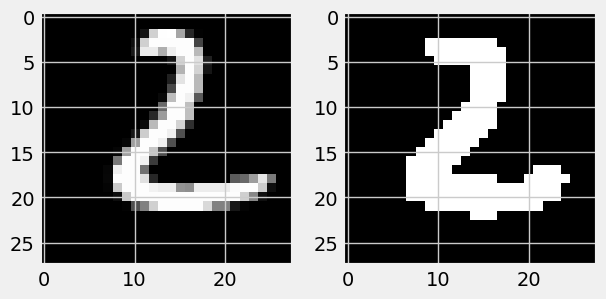

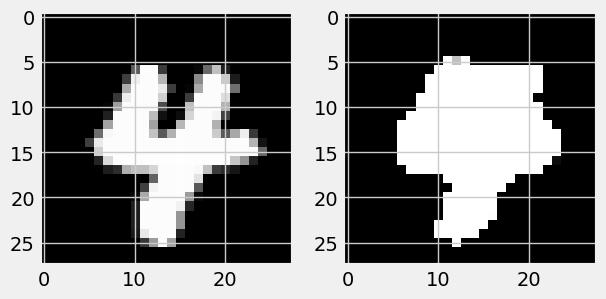

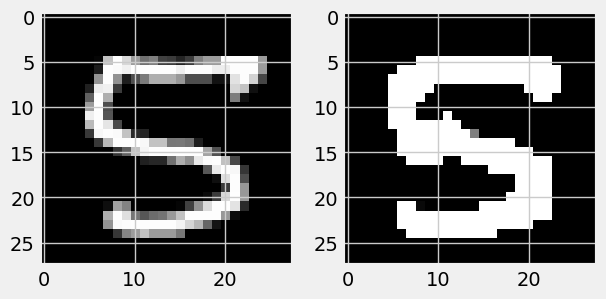

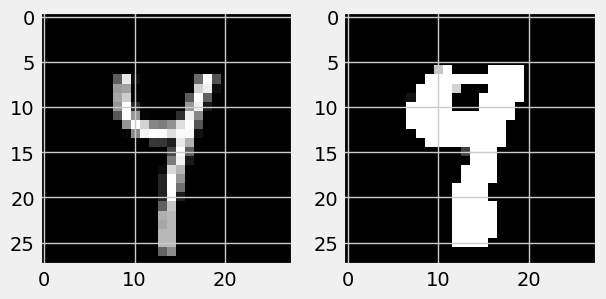

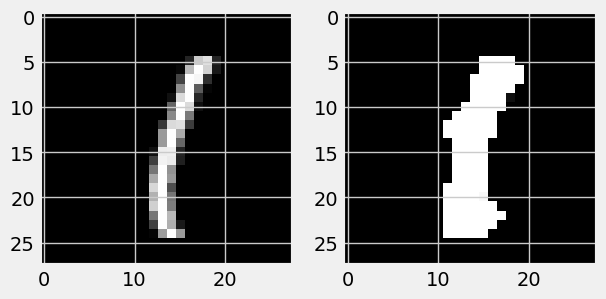

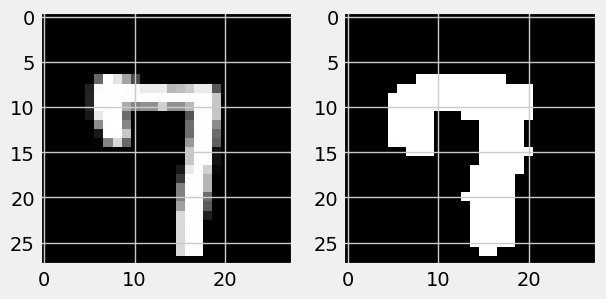

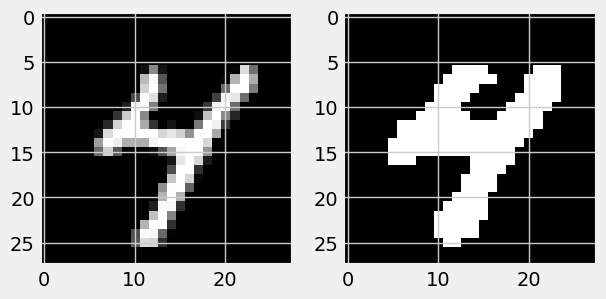

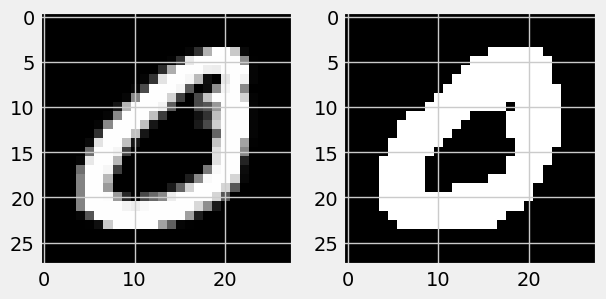

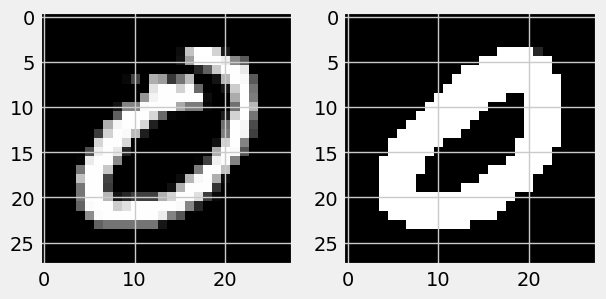

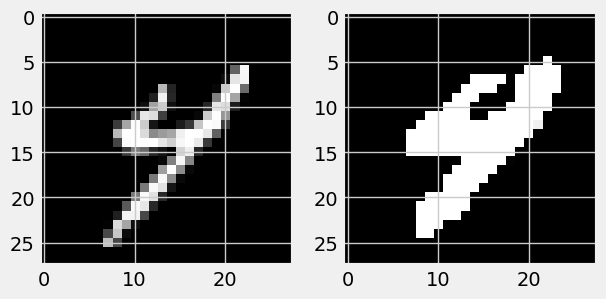

In [77]:
model.eval()

images = []

for i in range(10):
    images.append(train_set.data[np.random.randint(0, len(train_set))])
    
images = torch.stack(images)
images = images.view(images.size(0), -1)
images = images.type(torch.float32)
images = Variable(images).to(device)
with torch.no_grad():
    output = model(images).to(device)

output = output.cpu()
images = images.cpu()
output = output.reshape(-1, 28, 28)
images = images.reshape(-1, 28, 28)

for i in range(10):
    f = plt.figure()
    f.add_subplot(1,2, 1)
    plt.imshow(images[i], cmap='gray')
    f.add_subplot(1,2, 2)
    plt.imshow(output[i], cmap='gray')
    plt.show(block=True)

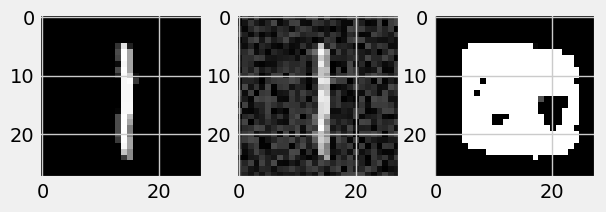

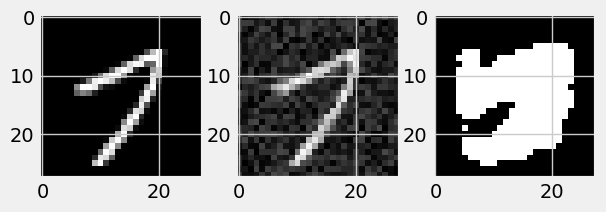

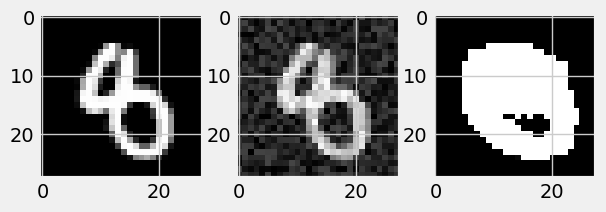

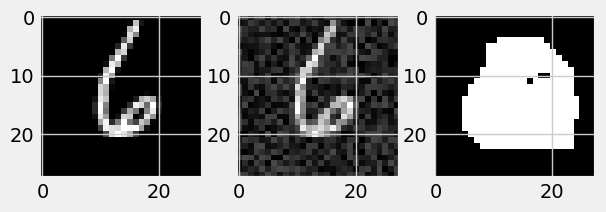

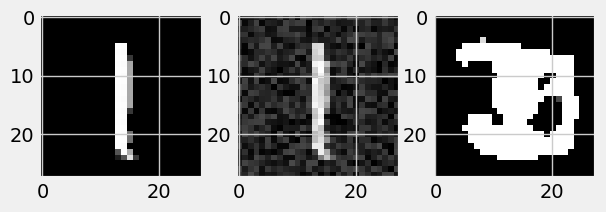

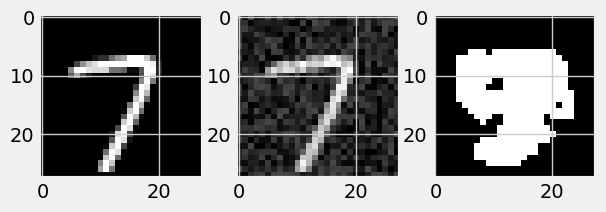

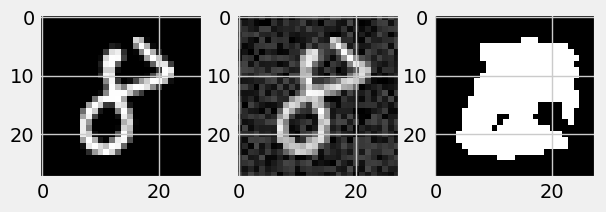

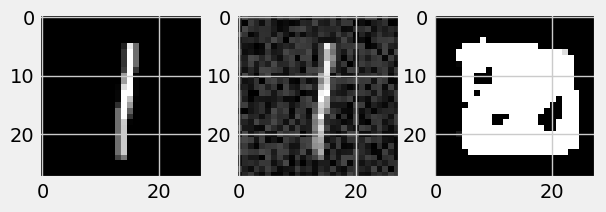

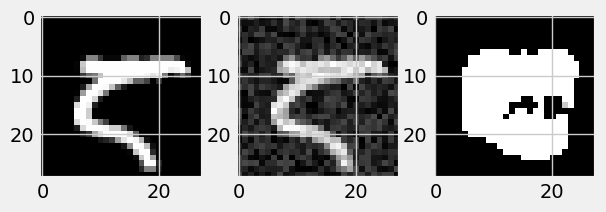

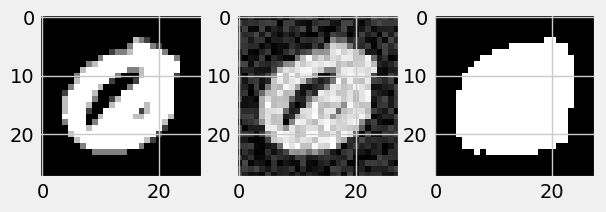

In [78]:
normal_images = []
images_with_noise = []

for i in range(10):
    training_image_idx = np.random.randint(0, len(train_set))   # get a random number from 0 to the length of the training set
    current_image = train_set.data[training_image_idx]          # grabbing the image from the dataset
    normal_images.append(current_image)    # append the normal image to this list
    images_with_noise.append(current_image + torch.rand(size=(28, 28))*100)    # append the same image with added noise to this list
    
images_with_noise = torch.stack(images_with_noise)
images_with_noise = images_with_noise.view(images_with_noise.size(0), -1)
images_with_noise = images_with_noise.type(torch.float32)
images_with_noise = Variable(images_with_noise).to(device)
with torch.no_grad():
    output = model(images_with_noise).to(device)

output = output.cpu()
images_with_noise = images_with_noise.cpu()
output = output.reshape(-1, 28, 28)
images_with_noise = images_with_noise.reshape(-1, 28, 28)

# the noisy image should be at the same index in it's list as its corresponding noiseless image
for i, current_image in enumerate(images_with_noise):
    f = plt.figure()
    f.add_subplot(1,3,1)
    plt.imshow(normal_images[i], cmap='gray')
    f.add_subplot(1,3,2)
    plt.imshow(images_with_noise[i], cmap='gray')
    f.add_subplot(1,3,3)
    plt.imshow(output[i], cmap='gray')
    plt.show(block=True)

In [96]:
images = []

for i in range(2):
    training_image_idx = np.random.randint(0, len(train_set))   # get a random number from 0 to the length of the training set
    current_image = train_set.data[training_image_idx]          # grabbing the image from the dataset
    images.append(current_image)

images = torch.stack(images)
images = images.view(images.size(0), -1)
images = images.type(torch.float32)
images = Variable(images).to(device)
with torch.no_grad():
    bottleneck_tensors = model.encode(images).to(device)
    interpolated = torch.lerp(images[0], images[1], 0.5)
    print(interpolated)
    output = model.decode(interpolated).to(device)

print(f"the output right after with: {output}")

bottleneck_tensors = bottleneck_tensors.cpu()
images = images.cpu()
output = output.cpu()
bottleneck_tensors = bottleneck_tensors.reshape(-1, 2, 16)
images = images.reshape(-1, 28, 28)
output = output.reshape(-1, 28, 28)

print(f"the output right before matplotlib: {output}")

f = plt.figure()
f.add_subplot(1,3,1)
plt.imshow(images[0], cmap='gray')

f.add_subplot(1,3,2)
plt.imshow(output, cmap='gray')

f.add_subplot(1,3,3)
plt.imshow(images[1], cmap='gray')
plt.show(block=True)

tensor([  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.00

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x784 and 16x392)